In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib qt

In [2]:
# Calibrate the camera for the given horozontal and vertical grid points
# Look at all of the images in the given folder to calibrate the camera
# Returns:
#       - mtx, dist points used in cv2.calibrateCamera

def calibCamera(nX, nY, folderName):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nY*nX, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nX, 0:nY].T.reshape(-1, 2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(folderName+'/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nX, nY), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nX, nY), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
            
    #cv2.destroyAllWindows()
    # Test undistortion on an image
    img = cv2.imread('camera_cal/calibration5.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            
    return mtx, dist

#### Verify/validate the functions

In [5]:
# Global variables
already_detected = False
nx = 9
ny = 6

In [6]:

mtx, dist  = calibCamera(nx, ny, 'camera_cal')

#### Functions

In [9]:


# Function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # Get Image dims in the form of (h,w)
    #img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist  

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist, show_grid = False):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undistorted = cal_undistort(img, mtx, dist)
    # Obj points for the images
    obj = np.float32([ [525,500], [764,500],  [1040,680], [261,680]])
    
    if (show_grid == True):
        cv2.line(undistorted, (obj[0][0], obj[0][1]), (obj[1][0], obj[1][1]), (255,0,0), 2)
        cv2.line(undistorted, (obj[1][0], obj[1][1]), (obj[2][0], obj[2][1]), (255,0,0), 2)
        cv2.line(undistorted, (obj[2][0], obj[2][1]), (obj[3][0], obj[3][1]), (255,0,0), 2)
        cv2.line(undistorted, (obj[3][0], obj[3][1]), (obj[0][0], obj[0][1]), (255,0,0), 2)
            
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    h_offset = 200
    v_offset = 0
    
    dst = np.float32([ [261,500], [1040,500],  [1040,680], [261,680]])
    #dst = np.float32([[h_offset, v_offset],
    #                    [img.shape[0]-h_offset, v_offset],
    #                    [img.shape[0]-h_offset, img.shape[1] - v_offset],
    #                    [h_offset, img.shape[1] - v_offset]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix and M_inv (inv transform matrix)
    M = cv2.getPerspectiveTransform(obj, dst)
    M_inv = cv2.getPerspectiveTransform(dst, obj)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped =  cv2.warpPerspective(undistorted, M, img_size)
    
    # Get unwarped image to see if M_inv is doing OK
    warp_img_size = (warped.shape[1], warped.shape[0])
    unwarped =  cv2.warpPerspective(warped, M_inv, warp_img_size)
    #delete the next two lines
    
    return warped, M, unwarped, M_inv


# Function that takes image, orientation, sobel kernel, threshold as input 
# returns the grayscale image with pixels set to 1 those that satisfied the threshold values
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = 0
    y = 0
    if (orient == 'x'):
        x = 1
    else:
        y = 1
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# Apply magnitude of the gradient threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)

    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

# Apply Direction of the gradient threshold
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad)
    dir_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

# Apply HLS (s channel) and gradient x thresholding
def hls_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Combine all of the above thresholds into one function
# Takes undistorted image as input
# Returns image that is filtered with all of the above thresholds
def combine_thresholds(undist_image):
    ksize = 15 # Choose a larger odd number to smooth gradient measurements
    dir_thresh_img = dir_threshold(undist_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    mag_thresh_img = mag_thresh(undist_image, sobel_kernel=ksize, mag_thresh=(30, 100))
    hls_thresh = hls_threshold(undist_image, (170, 255), (30, 100))
    
    combined_binary = np.zeros_like(dir_thresh_img)
    combined_binary[((dir_thresh_img == 1) & (mag_thresh_img == 1)) | (hls_thresh == 1)] = 1
    
    return combined_binary

# locate_lines() Function that takes an Image (warped) as input
# returns located left and right lanes indices, parameters for left and right lane polynomial eqn
# , non-zero pixels from the image, and the output image
def locate_lines(binary_warped):
    print(binary_warped.shape)
    print(binary_warped.shape[0]/2)
    #print(binary_warped[np.int32(binary_warped.shape[0]/2):,:])
    #binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    #plt.imshow(img, cmap='gray')
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #print(histogram.shape)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # map of returned values
    lines_data = {}
    lines_data['left_lane_inds'] = left_lane_inds
    lines_data['right_lane_inds'] = right_lane_inds
    lines_data['left_fit'] = left_fit
    lines_data['right_fit'] = right_fit
    lines_data['nonzerox'] = nonzerox
    lines_data['nonzeroy'] = nonzeroy
    lines_data['out_img'] = out_img  
    
    return lines_data

def locate_lines_with_known_fit(binary_warped, left_fit, right_fit):
    min_point_need = 20
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # See if there are min points to make sure that a line is found
    if ((leftx.shape[0] < min_point_need) or (rightx.shape[0] < min_point_need)):
        return None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # map of returned values
    lines_data = {}
    lines_data['left_lane_inds'] = left_lane_inds
    lines_data['right_lane_inds'] = right_lane_inds
    lines_data['left_fit'] = left_fit
    lines_data['right_fit'] = right_fit
    lines_data['nonzerox'] = nonzerox
    lines_data['nonzeroy'] = nonzeroy
    lines_data['out_img'] = out_img
    
    return lines_data

# Show the lines on the screen with detected lanes overlaid on the initial image
def visualize_lanes(orig_image, ret_data_from_lines, show_img = False):
    # Obj points for the images
    obj = np.float32([ [525,500], [764,500],  [1040,680], [261,680]])
    dst = np.float32([ [261,500], [1040,500],  [1040,680], [261,680]])
    # Generate x and y values for plotting
    left_fit = ret_data_from_lines['left_fit']
    right_fit = ret_data_from_lines['right_fit']
    out_img = ret_data_from_lines['out_img']

    # Warp the out_img back on to the original image
    warp_img_size = (out_img.shape[1], out_img.shape[0])
    unwarped_color =  cv2.warpPerspective(out_img, M_inv, warp_img_size)
    # Combine the lanes and the original image
    merged_img = cv2.addWeighted(orig_image, 1, unwarped_color, 0.3, 0)

    
    if (show_img == True):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(top_down)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(out_img)
        ax2.set_title('Lines overlapped on Warped Image', fontsize=50)
        ax3.imshow(merged_img)
        ax3.set_title('Merged Image', fontsize=50)
    
    return merged_img


def return_lanes_drawn_on_image(orig_image, left_fit, right_fit, m_inv, ave_rad, distance_c, show_img = False):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(orig_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp =  np.zeros((720, 1280, 3), dtype='uint8')

    ploty = np.linspace(0, orig_image.shape[0]-1, orig_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    label = 'Radius of the curve: %.2f m' %ave_rad
    result = cv2.putText(result, label, (20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #distance_c > 0 direction='left':direction='right'
    direction = 'left' if (distance_c < 0 ) else 'right'
    distance_c = np.abs(distance_c)    
    label = 'Vehicle is %.2f m %s of Center of the Lane' %(distance_c, direction)
    result = cv2.putText(result, label, (20,40+30), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    if (show_img == True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(top_down)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(out_img)
        ax2.set_title('Lines overlapped on Image', fontsize=50)

    return result
    
# Return the radius of left and right curves of the road in meters
# Takes the retrned values from locate_lanes() function that includes 
#     both lane indices, the non-zero pixels, and the polynomial factors
def return_curve_radius_in_mts(ret_data_from_lines):
    
    left_lane_inds = ret_data_from_lines['left_lane_inds']
    right_lane_inds = ret_data_from_lines['right_lane_inds']
    nonzerox = ret_data_from_lines['nonzerox']
    nonzeroy = ret_data_from_lines['nonzeroy']
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image, i.e 719 (height is 720 pixels)
    y_eval = 719
    
    # Define conversions in x and y from pixels space to meters
    # Here are the constants that I got from "Measuring Curvature" lesson 
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space  (multiply the x, y values by the scaling factor)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# Return the distance between center of the road (all lenas included) with the center of the vehicle (center of this lane)
#   Takes left and right fit coeffs
#   Returns the distance in meters
def return_distance_from_center(orig_image, left_fit, right_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Center is the mid point of the view
    center_of_the_view = orig_image.shape[1]/2
    
    # Find the left and right co-ordinates for at the botttom of the screen
    ploty = orig_image.shape[0]-1
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    distance_from_center = center_of_the_view - (left_fitx+right_fitx)/2
    # multiply by the factor to get in mts
    distance_from_center = distance_from_center*xm_per_pix
    
    return distance_from_center
    
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, max_list_count):
        # number of fitted line coefficents to store
        self.max_list_count = max_list_count
        # was the line detected in the last iteration?
        self.detected = False  
        # values of the last n fits of the line
        self.recent_fitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def get_fit_coeff(self):
        return self.best_fit
    
    def set_fit_coeff(self, coeff):
        self.recent_fitted.append(coeff)
        
        if (len(self.recent_fitted) > self.max_list_count):
            _ = self.recent_fitted.pop(0) 
        
        self.best_fit = np.average(self.recent_fitted, axis=0)
        return self.get_fit_coeff()

    
left_lane = Line(5)
right_lane = Line(5)
# def process_image(image)
# Stich together all the steps from above to
#     undistort the image
#     Apply the threshold (H, L, S and gradient) to find lanes
#     Get warped and unwarped images to draw lanes
#   
def process_image(image):
    
    global already_detected
    left_fit = []
    right_fit = []
    # Call undistort image function to remove any distortions from the camera 
    # mtx and dst are already mesured by the camera calibration function
    dst = cal_undistort(image, mtx, dist)
    
    # Apply thresholds to find images with lines 
    after_threshold = combine_thresholds(dst)
    
    # Get a perspective view of the image to find lanes from it
    warped, perspective_M, unwarped, M_inv = corners_unwarp(after_threshold, nx, ny, mtx, dist)
    
    # Now check for the lane detections
    if not already_detected:
        # Call locate_lines function to get the identified lane details
        ret_lane_details = locate_lines(warped)
        left_fit = ret_lane_details['left_fit']
        right_fit = ret_lane_details['right_fit']
        
        left_fit = left_lane.set_fit_coeff([left_fit[0], left_fit[1],left_fit[2]])
        right_fit = right_lane.set_fit_coeff([right_fit[0], right_fit[1],right_fit[2]])
        
        already_detected = True
    else:
        # If lane fit is already done before, use those fit coeff to find out it works?
        left_fit = left_lane.get_fit_coeff()
        right_fit = right_lane.get_fit_coeff()
        ret_lane_details = locate_lines_with_known_fit(warped, left_fit, right_fit)
        if ret_lane_details is not None:
            left_fit = ret_lane_details['left_fit']
            right_fit = ret_lane_details['right_fit']
            left_fit = left_lane.set_fit_coeff([left_fit[0], left_fit[1],left_fit[2]])
            right_fit = right_lane.set_fit_coeff([right_fit[0], right_fit[1],right_fit[2]])
        else:
            already_detected = False
    #return visualize_lanes(image, ret_lane_details) 
    left_rad, right_rad = return_curve_radius_in_mts(ret_lane_details)
    ave_rad = (left_rad + right_rad)/2
    # Get the distance from the center
    distance_c = return_distance_from_center(image, left_fit, right_fit)
    return return_lanes_drawn_on_image(image, left_fit, right_fit, M_inv, ave_rad, distance_c)
        
# def process_video(input_video, output_video)
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_video(input_video, output_video):

    clip2 = VideoFileClip(input_video)  #.subclip(0,5)
    out_clip = clip2.fl_image(process_image)
    %time out_clip.write_videofile(output_video, audio=False)


(720, 1280)
360.0
(720, 1280)
360.0
[MoviePy] >>>> Building video output_images/output.mp4
[MoviePy] Writing video output_images/output.mp4


100%|█████████▉| 1260/1261 [05:32<00:00,  3.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output.mp4 

CPU times: user 14min 56s, sys: 37.1 s, total: 15min 33s
Wall time: 5min 33s


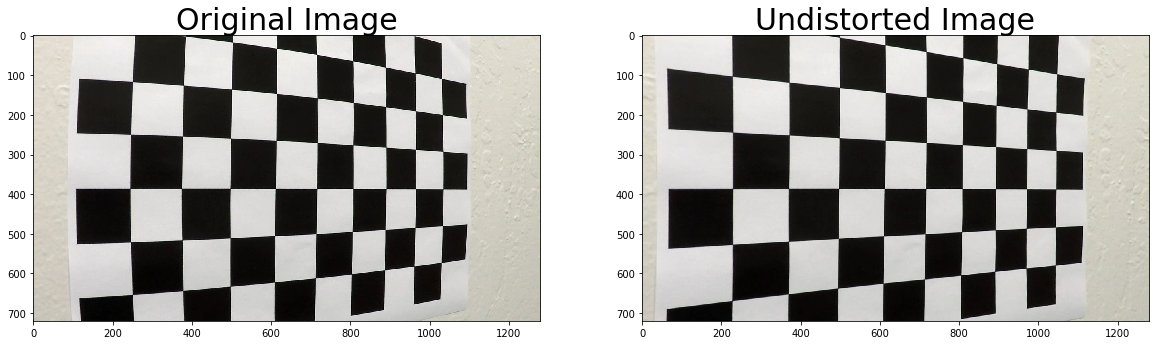

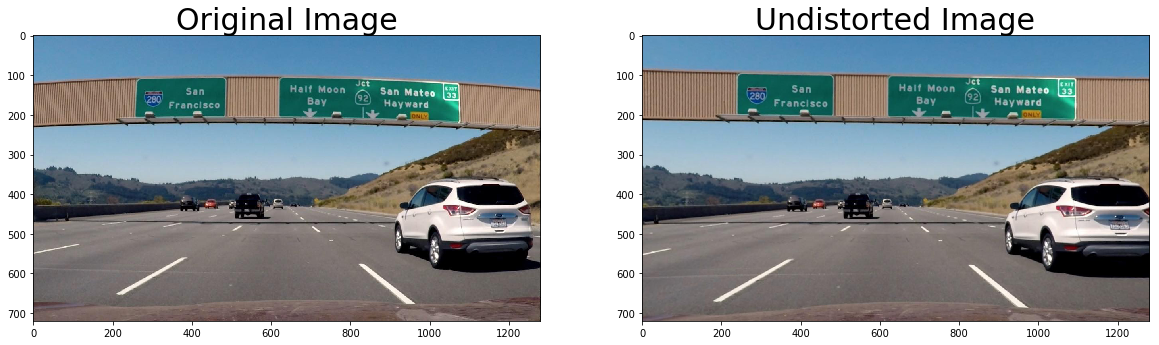

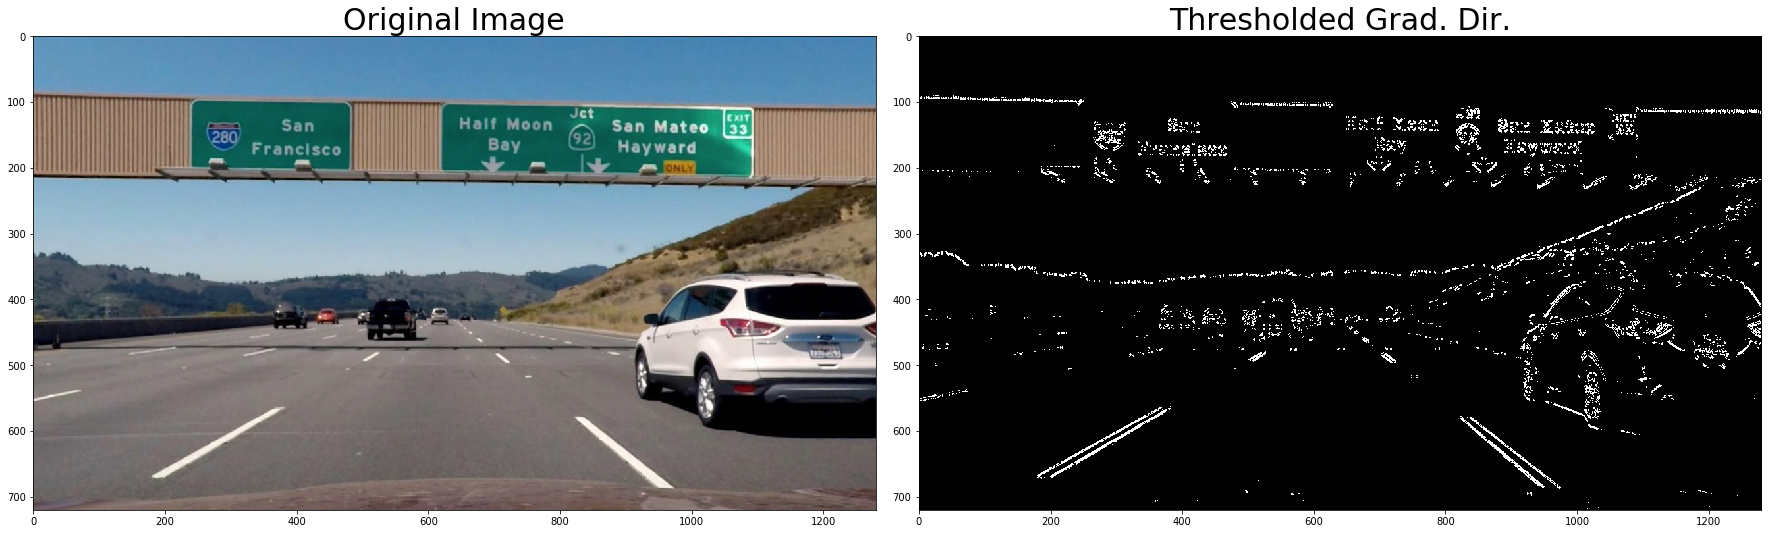

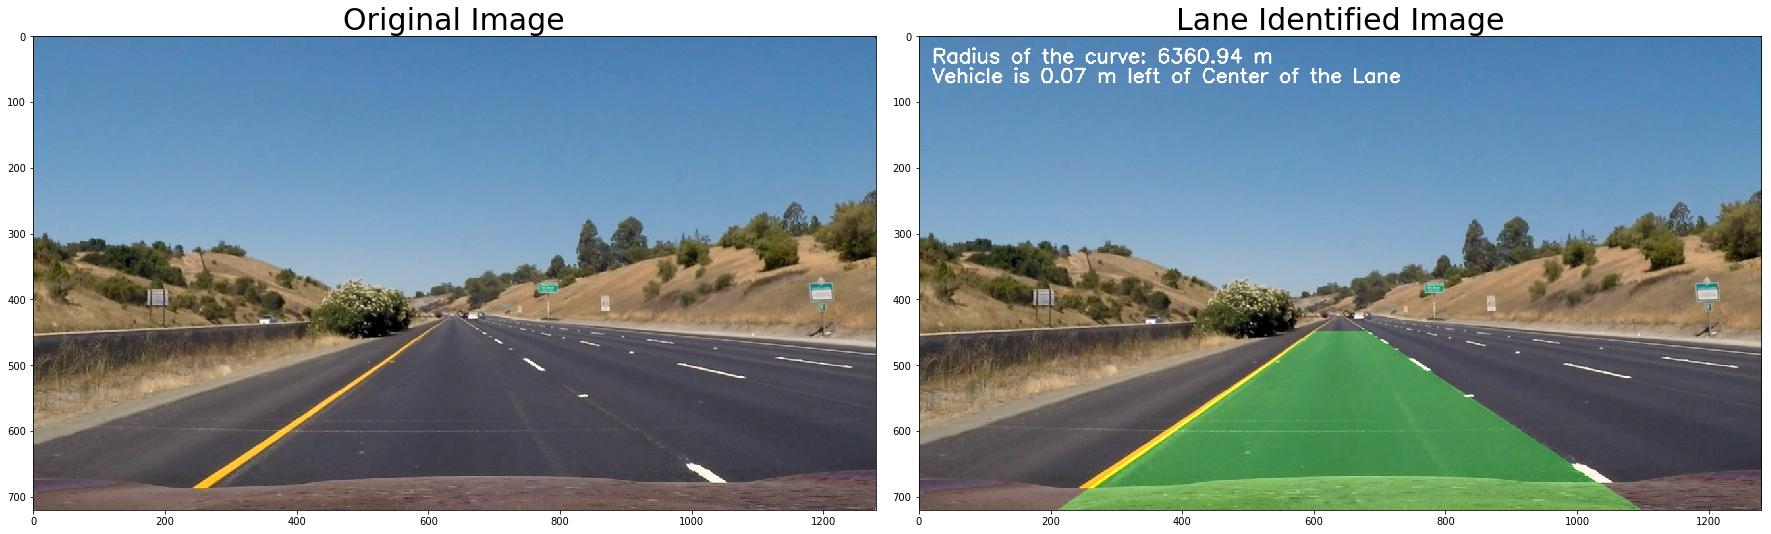

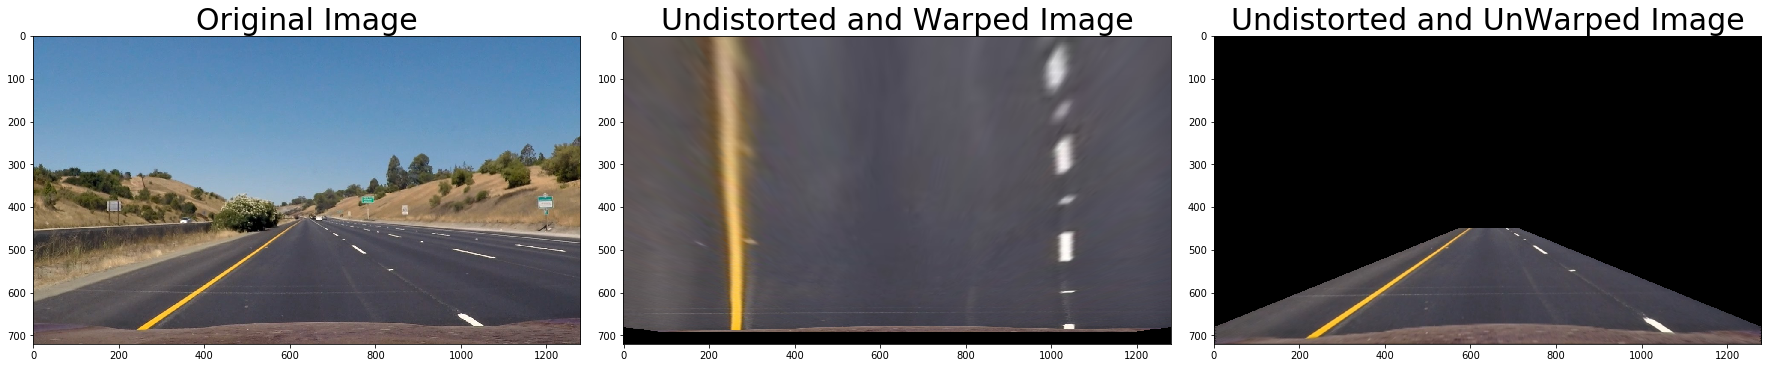

In [10]:
%matplotlib inline


# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration5.jpg')

dst = cal_undistort(img, mtx, dist)
cv2.imwrite('output_images/test_undist_checker.jpg', dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

img = mpimg.imread('camera_cal/signs_vehicles_xygrad.png')

dst = cal_undistort(img, mtx, dist)
cv2.imwrite('output_images/test_undist.jpg', dst)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Apply different threshold functions on the undistorted image to find the gradient lines
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Combined mask
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
cv2.imwrite('/home/ramesh/Pictures/combined_gradient_binary.jpg', dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Check for advacned pipeline using S channel & L Channel
result = hls_threshold(dst, (170, 255), (30, 100))

img = mpimg.imread('test_images/straight_lines1.jpg')
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
already_detected = False
result = process_image(img)
ax2.imshow(result)
ax2.set_title('Lane Identified Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Unwarp image test
#img = cv2.imread('test_images/straight_lines1.jpg')

img = mpimg.imread('test_images/straight_lines1.jpg')
top_down, perspective_M, unwraped, M_inv = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
ax3.imshow(unwraped)
ax3.set_title('Undistorted and UnWarped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Test for Lane detection within a video
already_detected = False
process_video('project_video.mp4', 'output_images/output.mp4')
#process_video('challenge_video.mp4', 'output_c.mp4')


#### Verify/validate the functions

obj points (530,500) (764,500), (261,680), (1040,680)